In [28]:
from climlab_rrtmg import rrtmg_lw, rrtmg_sw
import ephem
from matplotlib import pyplot as plt
import pandas as pd
import math
import xarray as xr
import numpy as np



In [29]:
# some good notes about radiation schemes
# https://repository.library.noaa.gov/view/noaa/49705

In [30]:
ds = xr.open_dataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/interpsond/sond_by_pressure2/all_sondes_withq_1h.nc")
ds = ds.rename({"bar_pres":"pressure"})


In [32]:
#qcrad = xr.open_mfdataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/qcrad/*")

In [4]:
aod=xr.open_mfdataset("/global/homes/r/rudisill/gshare/sail_data_will/data_store_sail_period/aod/ftp.archive.arm.gov/rudisillw2/242085/*.nc")

NameError: name 'xr' is not defined

In [5]:
albedo_clipped_suspect = sebs.albedo.clip(min=0).clip(max=1).to_pandas()

NameError: name 'sebs' is not defined

In [ ]:
# fig,ax = plt.subplots()
# aod.aod_500.to_pandas().resample("1w").apply(np.nanmean).plot(ax=ax, label='500nm')
# aod.aod_675.to_pandas().resample("1w").apply(np.nanmean).plot(ax=ax, label='675nm')
# aod.aod_1020.to_pandas().resample("1w").apply(np.nanmean).plot(ax=ax, label='1020nm')
# ax.set_ylabel("AOD")
# plt.legend()

In [ ]:
def calculate_solar_zenith_cosine(lat, lon, datetime_obj):
    observer = ephem.Observer()
    observer.lat = str(lat)
    observer.lon = str(lon)
    observer.date = datetime_obj

    sun = ephem.Sun(observer)
    solar_altitude = sun.alt

    # Calculate zenith angle (90 degrees - solar altitude)
    zenith_angle = math.pi / 2.0 - solar_altitude

    # Calculate cosine of zenith angle
    cos_zenith = math.cos(zenith_angle)

    return cos_zenith

### Read Ozone Data ... 
Here we are reading ozone data from the NOAA global monitoring lab 

here: https://gml.noaa.gov/ozwv/ozsondes/index.html

This is just looking at one day from April 2022. maybe it is worth looking at the actual ozone for that particular time 

In [ ]:
o3 = pd.read_csv("/global/u1/r/rudisill/ozone_profile_0422_bldr.csv")
o3=o3.sort_values(by="Press_hpa")
o3_interp = np.interp(np.linspace(10, 750, 100), o3.Press_hpa, o3.Ozone_ppmv)[::-1] * 10E-6

### DO THE LONGWAVE

In [ ]:
def test_rrtmg_lw_clearsky(itime):                        
    ######## MAKE INPUT DATA HERE ########
    # Specific heat at constant pressure
    cp = 1004.

    ptime = ds.isel(time=itime).pressure
    pdp   = ds.isel(time=itime).dp
    ps    = ptime.values[0] # ds.pressure.values[0] #  Surface pressure in hPa

    # layers 
    ncol = 1
    nlay = 100  # this is the number of layers. and there are nlay+1 number of interfaces

    #  pressure profile
    play = ptime.values[np.newaxis, ...]
    plev = (ptime - .5*pdp).interp(level=np.linspace(0, nlay-1, nlay+1)).values[np.newaxis, ...]

    #  temperature profile
    tlay = ds.isel(time=itime).temp.values[np.newaxis, ...] + 273.15
    tsfc = tlay[0,0] + 1
    tlev = (ds.isel(time=itime).temp.interp(level=np.linspace(0, nlay-1, nlay+1)) + 273.15).values[np.newaxis, ...]

    #  Water vapor profile
    #r = ds.isel(time=itime).r.values 
    # q= r / (1 + r)
    specific_humidity = ds.isel(time=itime).q.values 

    # Convert to volume mixing ratio from mass mixing ratio
    # just multiplying by ratio of molecular weights of dry air and H2O
    h2ovmr = specific_humidity * 28.97 / 18.01528
    h2ovmr = h2ovmr[np.newaxis, ...]

    # ozone profile...
    o3vmr = o3_interp[np.newaxis, :]## THIS IS A GLOBAL DEFINED ABOVE 

    # o3vmr = np.array([2.25573888e-08, 2.38730436e-08, 2.52586476e-08, 2.66442517e-08,
    #                   2.80298557e-08, 2.97254145e-08, 3.14254923e-08, 3.31238355e-08,
    #                   3.46767916e-08, 3.62297478e-08, 3.76122833e-08, 3.86410454e-08,
    #                   3.96698075e-08, 4.08899052e-08, 4.21303310e-08, 4.39781220e-08,
    #                   4.60528063e-08, 4.87636254e-08, 5.16974065e-08, 5.57122567e-08,
    #                   6.17914190e-08, 7.15771368e-08, 9.29020109e-08, 1.29109217e-07,
    #                   1.75914529e-07, 2.45552383e-07, 3.92764464e-07, 7.61726407e-07,
    #                   2.25137178e-06, 7.27500161e-06])

    # Generate new x-coordinates for the interpolated array
    old_indices = np.arange(len(o3vmr))
    new_indices = np.linspace(0, len(o3vmr) - 1, 100)  # 100 new indices

    # Perform linear interpolation using numpy.interp
#    o3vmr_interp = np.interp(new_indices, old_indices, o3vmr)
#    o3vmr = o3vmr_interp[np.newaxis, ...]

    # Other values taken from the AquaPlanet Experiment protocols,
    # except for O2 which is set the realistic value 0.21
    co2vmr   = 415. / 1E6 * np.ones_like(play)
    ch4vmr   = 1650. / 1E9 * np.ones_like(play)
    n2ovmr   = 306. / 1E9 * np.ones_like(play)
    o2vmr    = 0.21 * np.ones_like(play)
    cfc11vmr = 0. * np.ones_like(play)
    cfc12vmr = 0. * np.ones_like(play)
    cfc22vmr = 0. * np.ones_like(play)
    ccl4vmr  = 0. * np.ones_like(play)

    #  Cloud parameters
    cloud_level_index = 8
    cldfrac = 0. * np.ones_like(play) #*np.exp(-(play-play[0,cloud_level_index])**2/(2*25.)**2)  # Layer cloud fraction: a Gaussian centered on a pressure level
    clwp    = 0. * np.ones_like(play)  # in-cloud liquid water path (g/m2)
    ciwp    = 0. * np.ones_like(play)   # in-cloud ice water path (g/m2)
    relq    = 0. * np.ones_like(play) # Cloud water drop effective radius (microns)
    reic    = 0. * np.ones_like(play)  # Cloud ice particle effective size (microns)
    nbndlw = int(rrtmg_lw.parrrtm.nbndlw)
    ngptlw = int(rrtmg_lw.parrrtm.ngptlw)
  
    #  Initialize absorption data
    rrtmg_lw.climlab_rrtmg_lw_ini(cp)

    # Lots of RRTMG parameters
    icld        = 0    # Cloud overlap method, 0: Clear only, 1: Random, 2,  Maximum/random] 3: Maximum
    irng        = 1    # more monte carlo stuff
    idrv        = 0    # whether to also calculate the derivative of flux with respect to surface temp
    permuteseed = 300
    inflglw     = 2
    iceflglw    = 1
    liqflglw    = 1

    #  These arrays have an extra dimension for number of bands
    # in-cloud optical depth [nbndlw,ncol,nlay]
    tauc = 0. * np.ones_like(play)
    
    #  broadcast to get [nbndlw,ncol,nlay]
    tauc = tauc * np.ones([nbndlw,ncol,nlay])
    
    # Aerosol optical depth at mid-point of LW spectral bands [ncol,nlay,nbndlw]
    tauaer = 0 * np.ones_like(play)
    
    #  broadcast and transpose to get [ncol,nlay,nbndlw]
    tauaer = np.transpose(tauaer * np.ones([nbndlw,ncol,nlay]), (1,2,0))

    # surface emissivity
    emis = 1. * np.ones((ncol,nbndlw))

    # Clear-sky only
    cldfmcl = np.zeros((ngptlw,ncol,nlay))
    ciwpmcl = np.zeros((ngptlw,ncol,nlay))
    clwpmcl = np.zeros((ngptlw,ncol,nlay))
    reicmcl = np.zeros((ncol,nlay))
    relqmcl = np.zeros((ncol,nlay))
    taucmcl = np.zeros((ngptlw,ncol,nlay))

    for ispec in [0, 1]: # Spectral OLR output flag, 0: only calculate total fluxes, 1: also return spectral OLR
        # Call the RRTMG_LW driver
        (olr_sr, uflx, dflx, hr, uflxc, dflxc, hrc, duflx_dt, duflxc_dt) = \
                rrtmg_lw.climlab_rrtmg_lw(ncol, nlay, icld, ispec, idrv,
                     play, plev, tlay, tlev, tsfc,
                     h2ovmr, o3vmr, co2vmr, ch4vmr, n2ovmr, o2vmr,
                     cfc11vmr, cfc12vmr, cfc22vmr, ccl4vmr, emis,
                     inflglw, iceflglw, liqflglw, cldfmcl,
                     taucmcl, ciwpmcl, clwpmcl, reicmcl, relqmcl,
                     tauaer)
    return dflxc

In [47]:
ds.time

<xarray.DataArray 'time' (time: 15696)>
array(['2021-09-01T00:00:00.000000000', '2021-09-01T01:00:00.000000000',
       '2021-09-01T02:00:00.000000000', ..., '2023-06-16T21:00:00.000000000',
       '2023-06-16T22:00:00.000000000', '2023-06-16T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2021-09-01 ... 2023-06-16T23:00:00

In [48]:
dr = pd.date_range("2021-09-01", "2023-06-15", freq='1h')
lwdownc = np.zeros(len(dr))

In [49]:
for k in range(1, len(dr)):
    lwdownc[k] = test_rrtmg_lw_clearsky(k)[0,0]

In [50]:
lwdc = pd.DataFrame({"lwdc":lwdownc}, index=dr)

In [52]:
lwd = qcrad.down_long_hemisp.where(qcrad.qc_down_long_hemisp == 0)

In [53]:
lwd = lwd.to_pandas().resample("1h").mean()

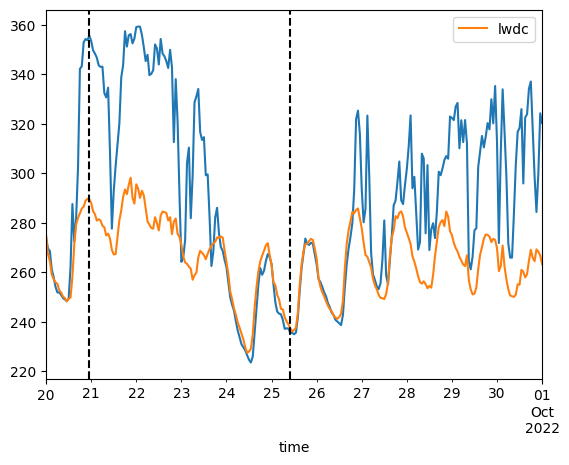

In [58]:
fig, ax = plt.subplots()

sd = pd.to_datetime("2022-09-20")
ed = pd.to_datetime("2022-10-01")


lwd.loc[sd:ed].plot(ax=ax, label='obs')
lwdc.loc[sd:ed].plot(ax=ax, label='model')

ax.axvline(pd.to_datetime("2022-09-20 23"), color='k', linestyle='--')
ax.axvline(pd.to_datetime("2022-09-25 10"), color='k', linestyle='--')

In [61]:
lwdc['qcrad_lwd'] = lwd

In [62]:
lwdc.to_csv("/global/cfs/cdirs/m4099/gsharing/sail_data_will/rrtmg/rrtmgClearSkyLW_SailPeriod.csv")

### CHECK OZONE

In [ ]:
# original ozone that was in the climlab code 
o3vmr = np.array([2.25573888e-08, 2.38730436e-08, 2.52586476e-08, 2.66442517e-08,
                    2.80298557e-08, 2.97254145e-08, 3.14254923e-08, 3.31238355e-08,
                    3.46767916e-08, 3.62297478e-08, 3.76122833e-08, 3.86410454e-08,
                    3.96698075e-08, 4.08899052e-08, 4.21303310e-08, 4.39781220e-08,
                    4.60528063e-08, 4.87636254e-08, 5.16974065e-08, 5.57122567e-08,
                    6.17914190e-08, 7.15771368e-08, 9.29020109e-08, 1.29109217e-07,
                    1.75914529e-07, 2.45552383e-07, 3.92764464e-07, 7.61726407e-07,
                    2.25137178e-06, 7.27500161e-06])

# intepolate 
nlay=100
old_indices = np.arange(len(o3vmr))
new_indices = np.linspace(0, len(o3vmr) - 1, nlay)  # 100 new indices

# Perform linear interpolation using numpy.interp
o3vmr_interp = np.interp(new_indices, old_indices, o3vmr)
o3vmr = o3vmr_interp[np.newaxis, ...]\


# read ozone data from the boulder sonde 
o3 = pd.read_csv("/global/u1/r/rudisill/ozone_profile_0422_bldr.csv")
o3=o3.sort_values(by="Press_hpa")
plt.plot(ds.isel(time=0).pressure, o3vmr[0,:])
#plt.plot(o3.Press_hpa, o3.Ozone_ppmv*10E-6, color='red')
plt.plot(ds.isel(time=0).pressure, np.interp(ds.isel(time=0).pressure.values[::-1], o3.Press_hpa, o3.Ozone_ppmv)[::-1] * 10E-6)

: 